#### 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from matplotlib import font_manager, rc
%matplotlib inline
from matplotlib import cm 

# 한글 폰트
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

pd.set_option('max_columns', 100, 'max_rows', 20)

## 0. 데이터 불러오기

In [2]:
# 추정 매출 
buy_data = pd.read_csv('./Data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_수정본.csv')
buy_data = buy_data.iloc[:,1:]
1
year_month = []
for i in range(buy_data.shape[0]):
    year_month.append(str(buy_data['기준_년_코드'].iloc[i]) + '-' + str(buy_data['기준_분기_코드'].iloc[i]))

buy_data['년-분기'] = year_month

# 대학 상권 list
college_commercial = pd.read_csv('./Data/대학인근상권.csv')
college_cm_name = list(college_commercial['TRDAR_CD_N'].unique())

# 상권 점포 데이터 
store_inf = pd.read_csv('./Data/서울시 우리마을가게 상권분석서비스(상권점포-통합).csv', low_memory=False)

### 해당 상권의 총 점포수 확인(프랜차이즈 점포수까지 확인)
store_inf['총_점포_수'] = store_inf['점포_수'] + store_inf['프랜차이즈_점포_수']

year_month = []
for i in range(store_inf.shape[0]):
    year_month.append(str(store_inf['기준_년_코드'].iloc[i]) + '-' + str(store_inf['기준_분기_코드'].iloc[i]))

store_inf['년-분기'] = year_month

In [3]:
def year_month(data):
    year_month = []
    
    for i in range(data.shape[0]):
        year_month.append(str(data['기준_년_코드'].iloc[i]) + '-' + str(data['기준_분기_코드'].iloc[i]))
    
    data['년-분기'] = year_month
    
    return data

## 1. 데이터 전처리(고정) 

- [1] 추정매출 데이터 中 상권 내에서 오탈자 문제: 종로?청계 관광특구(2020-4분기)
- [2] 상권점포 데이터 中 상권 내에서 오탈자 문제: 종로?청계 관광특구(2020-4분기)
- [3] 상권점포 데이터 中 특정 분기에만 등장하는 상권 제거: 48개의 상권(2020-4분기)
- [4] 상권점포 데이터에서 각 상권별 서비스 업종 추출(22개 분기 모두 등장하는 업종만 추출)

In [4]:
# (1) 추정매출 데이터 내 오탈자 변경
buy_data['상권_코드_명'] = buy_data['상권_코드_명'].agg(lambda x: '종로·청계 관광특구' if x =='종로?청계 관광특구' else x)

# (2) 상권 점포 데이터 내 오탈자 변경
store_inf['상권_코드_명'] = store_inf['상권_코드_명'].agg(lambda x: '종로·청계 관광특구' if x =='종로?청계 관광특구' else x)

# (3) 상권 개수 맞춰서 진행하기
store_point_list = list(store_inf[store_inf['년-분기'] == "2016-1"]['상권_코드_명'].unique())
store_inf = store_inf.query('상권_코드_명 in @ store_point_list')

In [5]:
#(4) 상권별 - 서비스 업종이 22개 등장하는 업종만 뽑기 
find_value = (store_inf.groupby(['상권_코드','서비스_업종_코드_명'])[['기준_년_코드','기준_분기_코드']].count() == 22).reset_index()
find_value = find_value[(find_value['기준_년_코드'] == True)]

#### 22분기에 등장하는 상권-서비스 업종 대응 list
commercial_code = []
service_type_code = []
for i in find_value['상권_코드'].unique():
    commercial_code.append(i)
    value_list = []
    find_value_part = find_value[find_value['상권_코드'] == i]
    for j in find_value_part['서비스_업종_코드_명'].unique():
        value_list.append(j)
        value_list = list(set(value_list))
    service_type_code.append(value_list)
    
#### 각 상권코드를 가지고 와서 query문으로 데이터 정제
selected_data = []
for num,i in enumerate(commercial_code):  
    price_df_1 = store_inf[store_inf['상권_코드'] == i]
    find_servicetype_list = service_type_code[num]
    
    price_df_2 = price_df_1.query('서비스_업종_코드_명 in @ find_servicetype_list')    
    # 상권코드와 조합되는 서비스 업종 코드명으로 데이터 정제 후 저장
    
    selected_data.append(price_df_2)
    
data_cm = pd.concat(selected_data)
#data_cm.to_csv('서울시 우리마을가게 상권분석서비스(상권점포-통합)_수정본(전처리).csv')

store_inf = data_cm
store_inf = store_inf.reset_index(drop = True)

In [6]:
# (1) clustring 전처리 - 추정매출 중분류 개념 생성

print("buy_data에 서비스 업종 종류: \n{}".format(list(buy_data.서비스_업종_코드_명.unique()))) # buy_data의 서비스 업종 확인
    
# 중분류 정의
food_type = ['한식음식점','양식음식점','분식전문점','패스트푸드점','중식음식점','치킨전문점','일식음식점']
desert_type = ['커피-음료' ,'제과점']
market_type = ['슈퍼마켓','편의점']
drunk_type = ['호프-간이주점'] 
game_type = ['당구장','노래방','PC방','골프연습장']
bueaty_type = ['미용실','네일숍','화장품','피부관리실']

# 
buy_data['서비스_업종_중분류'] = buy_data['서비스_업종_코드_명'].agg(lambda x: '음식점류' if x in food_type else '디저트류' 
                                                     if x in desert_type else '마켓류' if x in market_type else '주점류' 
                                                     if x in drunk_type else '오락류' if x in game_type else '미용뷰티류' 
                                                     if x in bueaty_type else '기타')

# 기타 중분류는 분류에서 제외
data = buy_data[buy_data['서비스_업종_중분류'] != '기타'].reset_index(drop = True)

# 대학상권만 가져오기
machul = data[data['상권_코드_명'].isin(college_cm_name)]
machul = machul.reset_index(drop=True)

buy_data에 서비스 업종 종류: 
['한식음식점', '편의점', '양식음식점', '분식전문점', '미용실', '제과점', '커피-음료', '한의원', '패스트푸드점', '가방', '일반의류', '슈퍼마켓', '중식음식점', '여관', '스포츠클럽', '세탁소', '당구장', '서적', '호프-간이주점', '반찬가게', '컴퓨터및주변장치판매', '시계및귀금속', '전자상거래업', '일식음식점', '치과의원', '치킨전문점', '의약품', '화초', '문구', '화장품', '핸드폰', '예술학원', '네일숍', '가구', '육류판매', '안경', '노래방', '외국어학원', '미곡판매', '자동차수리', '일반의원', '일반교습학원', '피부관리실', '조명용품', '의료기기', '인테리어', '가전제품', 'PC방', '애완동물', '스포츠 강습', '철물점', '청과상', '운동/경기용품', '섬유제품', '자동차미용', '신발', '골프연습장', '자전거 및 기타운송장비', '수산물판매', '가전제품수리', '완구', '부동산중개업', '고시원']


In [7]:
# (2) 상권별 평균 점포수 확인
check = machul.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '점포수', aggfunc = 'sum', 
                           fill_value = 0).sort_values(by = '2016-1')
check['평균_점포수'] = check.mean(axis = 1).round(2)

# 점포수가 적어 제거될 상권
except_cm = list(check.query('평균_점포수 <1').index)
print("점포수가 적어 제거될 상권: {}".format(except_cm))

# 해당 상권 제거
final_data = machul.query('상권_코드_명 != @except_cm').reset_index(drop=True)

print("최종 사용할 상권 수: {}개".format(len(final_data['상권_코드_명'].unique())))

점포수가 적어 제거될 상권: []
최종 사용할 상권 수: 315개


### (2) 상권 점포 전처리
- 싱권 점포에서 추정매출과의 데이터 동일성을 위해 동일한 전처리 진행 > (1) 
- 대학 상권 vs 서울 상권의 (코로나 기간: 2020년 이후) 개/폐업률 평균 비교

In [8]:
# 각 상권마다 중분류에서 기타를 제외한 부분을 추출
store_inf['서비스_업종_중분류'] =  store_inf['서비스_업종_코드_명'].agg(lambda x: '음식점류' if x in food_type else '디저트류' 
                                                     if x in desert_type else '마켓류' if x in market_type else '주점류' 
                                                     if x in drunk_type else '오락류' if x in game_type else '미용뷰티류' 
                                                     if x in bueaty_type else '기타')
reduce_store_inf = store_inf[store_inf['서비스_업종_중분류'] != '기타'].reset_index(drop = True)

# 상권점포-통합 데이터의 대학상권 추출
college_store_inf = reduce_store_inf .query('상권_코드_명 in @ college_cm_name')

# 추정매출간 점포수가 적었던 상권 제외 
college_store_inf = college_store_inf.query('상권_코드_명 != @except_cm').reset_index(drop=True)

display(store_inf.서비스_업종_중분류.unique())

array(['기타', '주점류', '음식점류', '디저트류', '미용뷰티류', '오락류', '마켓류'], dtype=object)

### (3) clustring feature

In [9]:
# 상권별 분기 매출금액
df = final_data.groupby(['상권_코드_명', '년-분기'])['분기당_매출_금액'].sum().reset_index()
df = df.rename(columns = {'분기당_매출_금액': '분기당_총매출금액'})

# seed 고정
seed = 0
np.random.seed(seed)

part_01_01 = df.set_index(['년-분기','상권_코드_명'])['분기당_총매출금액'].unstack().transpose()

# Task 1. 예년(2016 ~ 2018년도) 증감 평균(기하 평균)

## 1.1 17년, 18년도(작년 대비) 증가율 

result_list = []
columne_name = []
index_name = list(part_01_01.index)

for num, year in enumerate([2017, 2018]):
    num = num * 4 
    
    for i in range(0,4,1):
        value = num + i                           # index 맞추기
        quarter = i + 1                           # 분기

        point = part_01_01.iloc[:,value]          # 이전 년도 분기
        comparison = part_01_01.iloc[:,value + 4] # 비교 년도 분기 
        
        quarterly_change = comparison.T.div(point).round(4) # (비교 년도 분기 / 이전 년도 분기)
        result_list.append(quarterly_change)                # 값 추가하기 
        
        name = str(year) + '년도' + str(quarter) + '분기 증가율'  
        columne_name.append(name)
        
result_year_ofrat = pd.concat(result_list,axis = 1)       
result_year_ofrat.columns = columne_name

## 1.2 2개년도 증가율에 대한 평균(기하 평균)
result_avg = []
result_column_name = []
for j in range(0,4,1):
    geo_mean_01 = result_year_ofrat.iloc[:,j]
    geo_mean_02 = result_year_ofrat.iloc[:,j + 4]
    final_geo_mean = np.sqrt(geo_mean_01 * geo_mean_02)    # 17년 (분기별) 증가율 * 18년 (분기별) 증가율의 기하 평균
    result_avg.append(final_geo_mean)
    
    result_column = '{}분기 예년 증감 평균'.format(str(j+1))
    result_column_name.append(result_column)
    
result_before_covid = pd.concat(result_avg, axis = 1)
result_before_covid.columns = result_column_name
result_before_covid = result_before_covid.round(4)

# Task 2. 2018년도 대비 2020년도 상권별 매출액 증감(2년치 증가율이기 때문에 root 계산)
column_name2018 = [i for i in list(df['년-분기'].unique()) if '2018' in i]
column_name2020 = [i for i in list(df['년-분기'].unique()) if '2020' in i]
column = column_name2018 +column_name2020

covid_chenge_rate_spread = []
sales_inf_time = df.set_index(['년-분기','상권_코드_명'])['분기당_총매출금액'].unstack().transpose().loc[:,column]

for i in range(0,4,1):
    bef_point = sales_inf_time.T.iloc[i,:]        # 2018 년도 매출액
    aft_point = sales_inf_time.T.iloc[i + 4,:]    # 2020 년도 매출액
    result_covid = np.sqrt(aft_point.T.div(bef_point)).round(4) # root calcuation
    covid_chenge_rate_spread.append(result_covid)
    
result_after_covid = pd.concat(covid_chenge_rate_spread, axis = 1)
result_after_covid.columns = ['2020년 1분기 증가', '2020년 2분기 증가', '2020년 3분기 증가', '2020년 4분기 증가']

# Task3. feature로 사용할 코로나 영향도

influence_of_covid_list = []

for i in range(0,4,1):
    before_point = result_before_covid.iloc[:,i]    # 예년 평균 증감
    after_point = result_after_covid.iloc[:, i]     # 코로나 이후 증감
    influence_of_covid = after_point - before_point
    influence_of_covid_list.append(influence_of_covid)
    
feature_01 = pd.concat(influence_of_covid_list, axis = 1)
feature_01.columns = ['1분기 covid 영향력','2분기 covid 영향력','3분기 covid 영향력','4분기 covid 영향력']

# Task4. 분기별 코로나 영향도 평균(scatter x축)
main_variable_part01 = pd.DataFrame(feature_01.mean(axis= 1).round(4)).rename(columns = {0 : 'Covid 영향력'})

feature_01.head()

,1분기 covid 영향력,2분기 covid 영향력,3분기 covid 영향력,4분기 covid 영향력
상권_코드_명,,,,
가재울로6길,-0.0642,-0.0605,-0.0934,-0.0798
가좌로7길,-0.1146,-0.1867,-0.1446,-0.1822
갈현로1길,-0.4420,-0.4315,-0.5137,-0.2889
갈현로7길,-0.1092,-0.1342,-0.0741,-0.0507
강남시장_동작,0.2748,-0.0019,-0.0652,-0.2911


In [10]:
# feature 2 상권별 평균 점포 수
feature_02_01 = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', 
                                        values = '총_점포_수', aggfunc = 'sum', fill_value = 0)
feature_02_01['상권_평균_점포수'] = feature_02_01.loc[:,:].mean(axis = 1).round()
feature_02_01 = feature_02_01[['상권_평균_점포수']]
step_01 = feature_02_01.copy()

from sklearn.preprocessing import RobustScaler

step_01.iloc[:,:] = np.log(step_01.iloc[:,:])
# 점포 수에 대한 scaling 진행 
trans = RobustScaler()
feature_02_01_scaling = trans.fit_transform(step_01)

# scaling 데이터프레임화 
feature_02_01_scaling = pd.DataFrame(feature_02_01_scaling).round(4)
feature_02_01_scaling.index = list(feature_02_01.index)
feature_02_01_scaling.columns = ['상권_평균_점포수(scaling)']
feature_02_01_scaling = feature_02_01_scaling.reset_index().rename(columns = {'index' : '상권_코드_명'}).set_index('상권_코드_명')

# 데이터 프레임 합치기
result = pd.merge(feature_01.reset_index(), feature_02_01.reset_index(), on = '상권_코드_명').set_index('상권_코드_명')

# scaling 데이터 프레임 합치기 
part_scaling = pd.merge(feature_02_01.reset_index(), feature_02_01_scaling.reset_index(), 
                        on = '상권_코드_명')[['상권_코드_명','상권_평균_점포수(scaling)','상권_평균_점포수']]

result_scaling = pd.merge(feature_01.reset_index(), part_scaling, on = '상권_코드_명').set_index('상권_코드_명')
result_scaling.head()

,1분기 covid 영향력,2분기 covid 영향력,3분기 covid 영향력,4분기 covid 영향력,상권_평균_점포수(scaling),상권_평균_점포수
상권_코드_명,,,,,,
가재울로6길,-0.0642,-0.0605,-0.0934,-0.0798,0.1355,76.0
가좌로7길,-0.1146,-0.1867,-0.1446,-0.1822,-0.2520,53.0
갈현로1길,-0.4420,-0.4315,-0.5137,-0.2889,0.1068,74.0
갈현로7길,-0.1092,-0.1342,-0.0741,-0.0507,0.0000,67.0
강남시장_동작,0.2748,-0.0019,-0.0652,-0.2911,-1.9425,11.0


### (4) clustring 결과 EDA

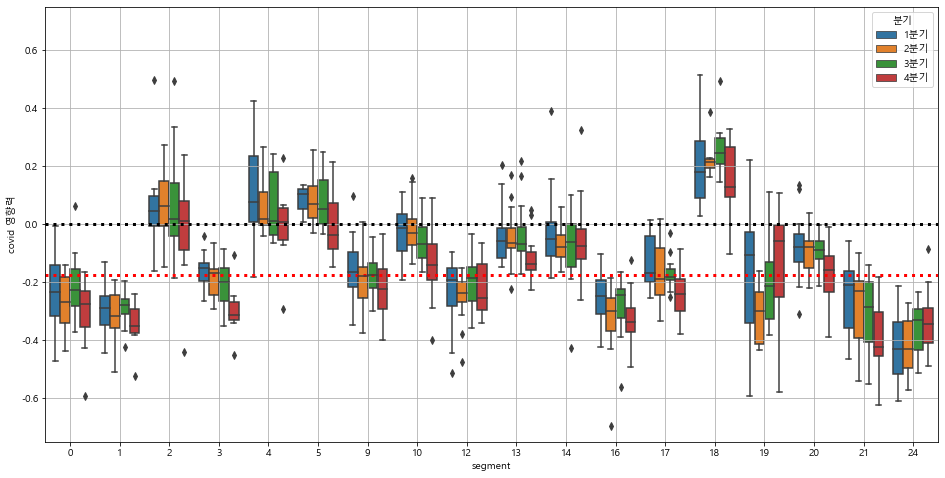

In [11]:
k = 25
for i in [k]:
    result_final = result_scaling .copy()
    inf_covid = feature_01.copy()
    inf_covid = inf_covid.reset_index()
    
    # kmean 적용 후 결과를 저장
    kmeans = KMeans(n_clusters=i, random_state=0).fit(result_final.iloc[:,:-1])
    result_final['segment'] = kmeans.labels_
    
    labels = result_final.value_counts('segment')[result_final.value_counts('segment') >= 5].sort_index().index

clustring_result = result_final.reset_index()[['상권_코드_명','segment']]
# clustring 결과 저장
# result_final.reset_index().to_csv('clustring_result.csv', index = False)

## 원본데이터 Frame
new = feature_01.reset_index()
eda_01 = pd.merge(new, result_final.reset_index()[['상권_코드_명','상권_평균_점포수','segment']], on ='상권_코드_명')

### 분기 분할
qur_01_inpact = eda_01[['상권_코드_명','1분기 covid 영향력','segment']].rename(columns = {'1분기 covid 영향력': 'covid 영향력'})
qur_02_inpact = eda_01[['상권_코드_명','2분기 covid 영향력','segment']].rename(columns = {'2분기 covid 영향력': 'covid 영향력'})
qur_03_inpact = eda_01[['상권_코드_명','3분기 covid 영향력','segment']].rename(columns = {'3분기 covid 영향력': 'covid 영향력'})
qur_04_inpact = eda_01[['상권_코드_명','4분기 covid 영향력','segment']].rename(columns = {'4분기 covid 영향력': 'covid 영향력'})

## 분기 feature 추가 
qur_01_inpact['분기'] = '1분기'
qur_02_inpact['분기'] = '2분기'
qur_03_inpact['분기'] = '3분기'
qur_04_inpact['분기'] = '4분기'

# 데이터 합치기
fact_01 = pd.concat([qur_01_inpact, qur_02_inpact, qur_03_inpact, qur_04_inpact], axis =0).reset_index().iloc[:,1:]
fact_01 = fact_01.sort_values(by = ['상권_코드_명','분기']).reset_index().iloc[:,1:]
fact_01.head(10)

fig, ax = plt.subplots(figsize = (16,8))

# order = order = [i for i in range(0, k, 1)]
total_avg = round(fact_01['covid 영향력'].mean(),4)

sns.boxplot(x = "segment", y = "covid 영향력", hue = "분기", data = fact_01.query('segment in @labels'), ax = ax)
plt.axhline(y = 0, color = 'black', linestyle = ':',linewidth = 3)
plt.axhline(y = total_avg, color = 'red', linestyle = ':',linewidth = 3)
plt.ylim([-0.75, 0.75])

plt.grid()
plt.show()

In [12]:
result_final.query('segment == 18').index

Index(['고척근린시장', '고척로27길', '대림골목시장', '아현시장', '왕십리로14길', '퇴계로18길'], dtype='object', name='상권_코드_명')

In [13]:
result_final

,1분기 covid 영향력,2분기 covid 영향력,3분기 covid 영향력,4분기 covid 영향력,상권_평균_점포수(scaling),상권_평균_점포수,segment
상권_코드_명,,,,,,,
가재울로6길,-0.0642,-0.0605,-0.0934,-0.0798,0.1355,76.0,20
가좌로7길,-0.1146,-0.1867,-0.1446,-0.1822,-0.2520,53.0,0
갈현로1길,-0.4420,-0.4315,-0.5137,-0.2889,0.1068,74.0,24
갈현로7길,-0.1092,-0.1342,-0.0741,-0.0507,0.0000,67.0,14
강남시장_동작,0.2748,-0.0019,-0.0652,-0.2911,-1.9425,11.0,4
...,...,...,...,...,...,...,...
휘경로2길,-0.1674,-0.2312,-0.1936,-0.3385,1.1811,201.0,17
휘경로3길,-0.2536,-0.3003,-0.2331,-0.2885,0.6085,118.0,16
흑석로13길,0.1565,0.0245,-0.0619,-0.1103,-0.2122,55.0,14


## 3. 상권 분석 변수

### (0) covid 영향력과 각 상권별 분포도 확인

- x축: covid 영향력(4분기 평균) 
- y축: 상권별 점포수: scaling(log 이후 robust 값 적용)

In [14]:
def cm_scatter(x = None):
    fig, ax = plt.subplots(figsize =(20,15))

    ax.scatter(main_variable['Covid 영향력'], main_variable['상권_평균_점포수(scaling)'], cmap='coolwarm', s = x)

    ax.set_xlabel("Covid 영향력", fontsize=15)
    ax.set_ylabel("상권 평균 점포수", fontsize=15)
    ax.set_title('상권 위치 확인', fontsize = 20)
    ax.grid()

    # x,y축 그리기
    plt.axvline(x = 0, color='black', linewidth=3)
    plt.axhline(y = 0, color='black', linewidth=3)
    
def cm_scatter02(data, x, y, hover_name = None, color = None): # size = None, size_max = None):
    import plotly.express as px
    
    plt.figure(figsize = (20,15))
    
    fig = px.scatter(data_frame = data, x= x, y= y, color= color, 
                 hover_name= hover_name) #size = size , size_max= size_max)

    fig.update_layout(title_text = "상권 scatter plot", title_font_size = 20, 
                      title_font_family = "맑은 고딕", title_font_color ='blue')

    display(fig)

In [ ]:
#1. segment의 분포도 확인: 상당히 잘 뭉쳐져 있음
a = college_store_inf[['상권_구분_코드_명','상권_코드_명']].drop_duplicates('상권_코드_명')

main_variable = pd.merge(main_variable_part01.reset_index(), 
                         part_scaling, on = '상권_코드_명').merge(clustring_result, on ='상권_코드_명')
main_variable= pd.merge(main_variable, a, on ='상권_코드_명').set_index('상권_코드_명')

import plotly.express as px

main_variable = main_variable.sort_values(by = 'segment')
main_variable['segment'] = main_variable['segment'].astype('str')

plt.figure(figsize = (20,15))

fig = px.scatter(data_frame =  main_variable.reset_index(), 
                 x='Covid 영향력', y='상권_평균_점포수(scaling)', color='상권_구분_코드_명', 
                 hover_name= '상권_코드_명') #size='pop', size_max=50, log_x=True)

fig.update_layout(title_text = "상권 scatter plot", title_font_size = 20, 
                  title_font_family = "맑은 고딕", title_font_color ='blue',)

display(fig)

main_variable = pd.merge(main_variable_part01.reset_index(), 
                         part_scaling, on = '상권_코드_명').merge(clustring_result, on ='상권_코드_명')
main_variable= pd.merge(main_variable, a, on ='상권_코드_명').set_index('상권_코드_명')
main_variable

### (1) 변수 만들기(상권별 비교 분석 feature)

#### [1] 점포 데이터

- 16 ~ 19년도의 개/폐업률 평균(산술) vs 20년  개/폐업률 평균(산술)
    
    [1] 의미: 예년 개.폐업률 평균보다 
    
    [2] 계산: 20년 개/폐업률 평균 - 16 ~ 19년도의 개/폐업률 평균(산술)
    
    [3] 한계: 추세를 반영하지 못한 feature 
    
-  16 ~ 20년도까지의 개.폐업률 추세상 영향도 확인

    [1] 의미:개/폐업률에 대한 이전 추세에 대해 상대적으로 개/폐업률에 대한 코로나의 영향
    
    [2] 계산: (해당 년도 개/폐업률 - 이전 년도 개/폐업률) 계산 후 > 코로나 평균 - 예년 평균

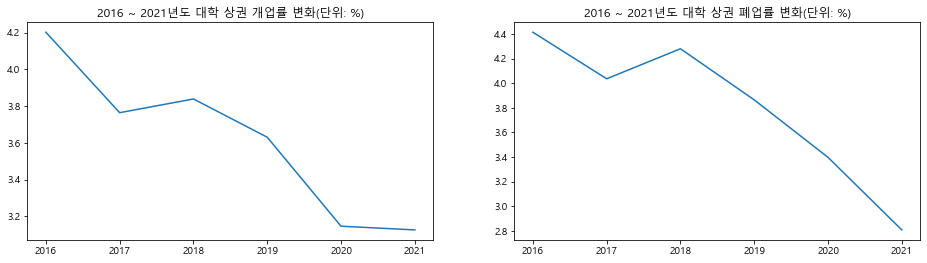

In [18]:
# Feature 1 ~2 만들기 위한 작업 

## 분기별 점포 수 /개업 혹은 폐업한 점포수 pivot-table
store_cnt_bycma = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '총_점포_수', \
                                                aggfunc = 'sum',fill_value = 0)

openstore_cnt_bycma = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '개업_점포_수', 
                                                    aggfunc = 'sum',fill_value = 0)

closestore_cnt_bycma = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '폐업_점포_수', \
                                                     aggfunc = 'sum',fill_value = 0)

## 분기별 개/폐율
openstore_ratio_bycma = openstore_cnt_bycma.div(store_cnt_bycma) * 100
closestore_ratio_bycma = closestore_cnt_bycma.div(store_cnt_bycma) * 100


openstore_ratio_year = []
closestore_ratio_year = []

# 2016 ~ 2021년 연도별 개.폐율 평균 구하기
for num in range(6):
    if num != 5: 
        num = num * 4
        part_open = openstore_ratio_bycma.iloc[:, num : num + 4]
        part_close = closestore_ratio_bycma .iloc[:, num : num + 4]
    else: 
        part_open = openstore_ratio_bycma.iloc[:, 20:]
        part_close = closestore_ratio_bycma .iloc[:, 20:]
        
    year_average_open = part_open.mean(axis = 1).round(4)
    year_average_close = part_close.mean(axis = 1).round(4)
    
    openstore_ratio_year.append(year_average_open)
    closestore_ratio_year.append(year_average_close)
    
# 데이터 합치기 
openstore_year = pd.concat(openstore_ratio_year, axis = 1)
openstore_year.columns = ['2016','2017','2018','2019','2020','2021']

closestore_year = pd.concat(closestore_ratio_year, axis = 1)
closestore_year.columns = ['2016','2017','2018','2019','2020','2021']

# 년도별 개.폐율 추세 확인하기 (전반적인 추세상 둘다 감소하는 추세 확인)
fig, ax = plt.subplots(1, 2, figsize = (16,4))

openstore_year.mean().plot(ax = ax[0], title = '2016 ~ 2021년도 대학 상권 개업률 변화(단위: %)')

closestore_year.mean().plot(ax = ax[1], title = '2016 ~ 2021년도 대학 상권 폐업률 변화(단위: %)')
plt.show()

In [19]:
# feature 01: 코로나 이후 평균 개/폐업률 - 코로나 이전 평균 개.폐업률(코로나 전후로 캐/폐업률 증가 여부)  
part_01 = (openstore_year.iloc[:,4] - openstore_year.iloc[:,:4].mean(axis = 1)).round(4).reset_index().rename(columns = {0 :'개업률 변화(코로나 대비)'})

part_02 = (closestore_year.iloc[:,4] - closestore_year.iloc[:,:4].mean(axis = 1)).round(4).reset_index().rename(columns = {0 :'폐업률 변화(코로나 대비)'})

feature_01 = pd.merge(part_01, part_02, on = '상권_코드_명')

display(feature_01)

# feature 02: 코로나로 인한 개/폐업률의 영향력(추세 제거)
open_1 = openstore_year.iloc[:,:-1]
close_1 = closestore_year.iloc[:,:-1]

open_trend_list = []
close_trend_list = []

for i in range(4):
    previous_open = openstore_year.iloc[:, i]       # 이전 년도 개업률 
    present_open = openstore_year.iloc[:, i + 1]     # 현재 개업률 
    trend_value_open = present_open - previous_open  # 추세(현재 개업률 - 이전 년도 개업률)
    open_trend_list.append(trend_value_open)
    
    previous_close = closestore_year.iloc[:, i]       # 이전 년도 폐업률 
    present_close = closestore_year.iloc[:, i + 1]     # 현재 폐업률 
    trend_value_close = present_close - previous_close # 추세(현재 폐업률 - 이전 년도 폐업률)
    close_trend_list.append(trend_value_close)

open_trend = pd.concat(open_trend_list, axis = 1)
close_trend = pd.concat(close_trend_list, axis = 1)

# 코로나 기간(2020- 2019) 개업률 - 예년 개업률 변화량 평균 (폐업률도 동일)
part_03 = (open_trend.iloc[:,-1:].mean(axis = 1) - 
           open_trend.iloc[:,:3].mean(axis = 1)).round(4).reset_index().rename(columns = {0 :'개업률_코로나영향(추세 제거)'})

part_04 = (close_trend.iloc[:,-1:].mean(axis = 1) - 
           close_trend.iloc[:,:3].mean(axis = 1)).round(4).reset_index().rename(columns = {0 :'폐업률_코로나영향(추세 제거)'})

feature_02 = pd.merge(part_03, part_04, on = '상권_코드_명')

display(feature_02)

,상권_코드_명,개업률 변화(코로나 대비),폐업률 변화(코로나 대비)
0,가재울로6길,-0.2683,-0.3725
1,가좌로7길,-0.3779,-1.8428
2,갈현로1길,-0.5277,-1.9776
3,갈현로7길,2.1161,-0.7833
4,강남시장_동작,-0.6564,4.2279
...,...,...,...
312,휘경로2길,-0.8588,-0.9079
313,휘경로3길,-2.0319,-1.4777
314,흑석로13길,-2.4509,-1.2492
315,흑석로9길,-3.6894,-2.7612


,상권_코드_명,개업률_코로나영향(추세 제거),폐업률_코로나영향(추세 제거)
0,가재울로6길,0.1186,1.8774
1,가좌로7길,0.6898,-0.6744
2,갈현로1길,0.0344,0.9037
3,갈현로7길,0.4078,-3.0221
4,강남시장_동작,-1.7201,5.6167
...,...,...,...
312,휘경로2길,0.3806,-1.1076
313,휘경로3길,-0.6979,-9.0452
314,흑석로13길,-2.7264,3.3355
315,흑석로9길,-5.0319,-4.7045


- 점포 수의 변화율 / 변화의 표준편차(정도) 

    [1] 의미: 점포 수의 변화율에 대한 코로나 전 후를 비교
    
    [2] 계산: (해당 년도 점포수 - 이전 년도 점포수) / 이전 년도 점포수 >> 코로나 기간(2020-2019) - 예년 평균 
    
    [3] 추가: 2016 - 1분기 ~ 2020 - 4분기 20개월의 점포수의 표준편차(변화 정도) / 왜곡의 위험

- 프랜차이즈 점포의 대한 내용

    [1] 2016년 ~ 2020년의 상권의 프랜차이즈 비율: 해당 상권의 프랜차이즈 정도를 파악
    
    [2] 2020년 프랜차이즈 비율의 산술 평균 - 2016 ~ 2019년 프렌차이즈 비율의 산술 평균: 코로나 전 후로 상대적인 프랜차이즈 비율 증가여부
    
    [3]

In [20]:
store_cnt_list = []

# 연도별 점포 수 데이터
for num in range(6):
    if num != 5: 
        num = num * 4
        part_cnt = store_cnt_bycma.iloc[:, num : num + 4]
    else: 
        part_cnt = store_cnt_bycma.iloc[:, 20:]
        
    year_mean_store = part_cnt.mean(axis = 1)
    store_cnt_list.append(year_mean_store)
    
# 데이터 합치기 
store_year = pd.concat(store_cnt_list, axis = 1)
store_year.columns = ['2016','2017','2018','2019','2020','2021']

In [21]:
# feature3. 점포수의 변화에 대한 정보(변화율, 표준편차)
change_rate_storecnt_list = []
for i in range(0,4,1):
    bef_cnt = store_year.T.iloc[i,:]        # 이전 년도 점포수
    aft_cnt = store_year.T.iloc[i + 1,:]    # 해당 년도 점포수
    result_cnt = aft_cnt.div(bef_cnt).sub(1)
    change_rate_storecnt_list.append(result_cnt)

change_rate_storecnt = pd.concat(change_rate_storecnt_list, axis = 1)
part_05 = (change_rate_storecnt.iloc[:,3] - 
           change_rate_storecnt.iloc[:,:3].mean(axis = 1)).round(4).reset_index().rename(columns = {0 :'점포수 변화율(추세 반영)'})

part_06 = store_cnt_bycma.iloc[:,:-2].std(axis = 1).reset_index().rename(columns = {0 :'점포수 표준편차'}).round(2)

feature_03 = pd.merge(part_05, part_06, on = '상권_코드_명')

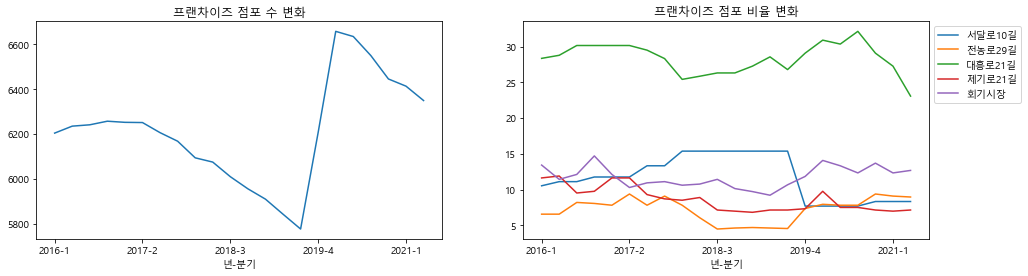

In [22]:
# feature4. 프랜차이즈 점포 비율
franchise_cnt = college_store_inf.pivot_table(index = '상권_코드_명', 
                                              columns = '년-분기', aggfunc = 'sum', values = '프랜차이즈_점포_수')

franchise_ratio = (franchise_cnt.div(store_cnt_bycma) * 100).round(2) # 프랜차이즈 점포 수 비율

# 이런 추세는 특정 상권들의 모음으로 이루어짐
fig, ax = plt.subplots(1, 2, figsize = (16,4))
franchise_cnt.sum().T.plot(ax = ax[0], title = '프랜차이즈 점포 수 변화') 
franchise_ratio.sample(5).T.plot(ax = ax[1], title = '프랜차이즈 점포 비율 변화') 
plt.legend(bbox_to_anchor = (1.0,1.0))

plt.show()

# 상권의 프랜차이즈 비율(5개 년도)
part_07 = franchise_ratio.mean(axis = 1).round(2).reset_index().rename(columns = {0 :'프랜차이즈_점포_비율'})

franchise_cal = franchise_ratio.iloc[:,:-2]
frahcnise_year = []

# 2016 ~ 2020년 연도별 프렌차이즈 점포 수 비율 평균 구하기
for num in range(5): 
    num = num * 4
    franchise_year_individual = franchise_ratio.iloc[:, num : num + 4]
    franchise_year_val = franchise_year_individual.mean(axis = 1).round(4)
    frahcnise_year.append(franchise_year_val)
    
franchise_year = pd.concat(frahcnise_year, axis = 1)
franchise_year.columns = [2016,2017,2018,2019,2020]

# 2020년 프랜차이즈 점포 비율 - (2016 ~ 2019년 점포 비율 평균)
part_08 = (franchise_year.iloc[:,4] - 
           franchise_year.iloc[:,:4].mean(axis = 1).round(4)).reset_index().rename(columns = {0 :'프랜차이즈_점포_비율변화(전후)'})

# 프랜차이즈 점포 비율(5개년 평균), 코로나 전후의 프랜차이즈 점포 비율 차이
feature_04 = pd.merge(part_07, part_08, on = '상권_코드_명')

In [23]:
# feature 05: 코로나로 인한 상권 프렌차이점 비율 영향력(추세 제거)
franchise_trend_list = []

for i in range(4):
    previous_franchise_ratio = franchise_year.iloc[:, i]                    # 이전 년도 비율
    present_franchise_ratio = franchise_year.iloc[:, i + 1]                 # 현재 비율 
    trend_value_ratio = present_franchise_ratio - previous_franchise_ratio  # 추세(현재 개업률 - 이전 년도 개업률)
    franchise_trend_list.append(trend_value_ratio)
    
franchise_impact = pd.concat(franchise_trend_list, axis = 1)

# feature_05: 코로나 기간(2020- 2019) 개업률 - 예년 개업률 변화량 평균 (폐업률도 동일)
feature_05 = (franchise_impact.iloc[:,-1:].mean(axis = 1) - 
              franchise_impact.iloc[:,:3].mean(axis = 1)).round(4).reset_index().rename(columns = {0 :
                                                                                                   '프랜차이점비율_코로나영향(추세 제거)'})

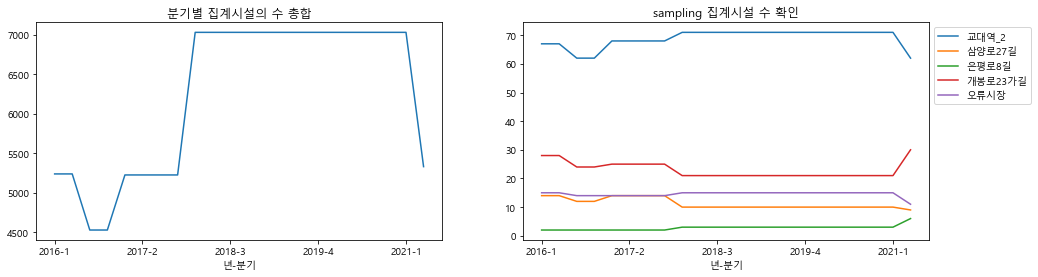

In [24]:
# 집객 시설 데이터 전처리 
visit_facility = pd.read_csv('./Data/서울시 우리마을가게 상권분석서비스(상권-집객시설).csv', encoding = 'cp949')
year_month(visit_facility)

visit_facility_inf = visit_facility.query('기준_년_코드 != 2015')                                    # 년도 query
visit_facility_inf = visit_facility_inf.query('상권_코드_명 in @ college_cm_name')                   # 대학 상권 추출
college_facility_inf = visit_facility_inf.query('상권_코드_명 != @except_cm').reset_index(drop=True) # 제외 상권 제외 
college_facility_inf = college_facility_inf.fillna(0)  # null값 0으로 채우기

# 상권별 집객시설 수
college_facility_cm = college_facility_inf.groupby(['상권_코드_명', '년-분기'])['집객시설_수'].sum().reset_index()
college_facility_cm = college_facility_cm.set_index(['년-분기','상권_코드_명'])['집객시설_수'].unstack().transpose().fillna(0)

# 상위 개념으로 정의하기 (교육시설[대학 제외, 유치원 포함] / 의료시설[병원 + 약국] / 공기관[관공서 + 은행] / 소매점 [백화점 + 마켓])
college_facility_inf['교육시설_수'] = (college_facility_inf['유치원_수'] + college_facility_inf['초등학교_수'] +
                                  college_facility_inf['중학교_수'] + college_facility_inf['고등학교_수'])

college_facility_inf['의료시설_수'] = (college_facility_inf['종합병원_수'] + college_facility_inf['일반_병원_수'] +
                                  college_facility_inf['약국_수'])

college_facility_inf['공기관_수'] = (college_facility_inf['관공서_수'] + college_facility_inf['은행_수'])

college_facility_inf['소매점_수'] = (college_facility_inf['백화점_수'] + college_facility_inf['슈퍼마켓_수'])


# 데이터 이상치 확인 EDA: 확실히 이상항 사용 시 최빈값을 대푯값으로 사용
fig, ax = plt.subplots(1,2, figsize = (16,4))
college_facility_cm.sum().plot(ax = ax[0], title = '분기별 집계시설의 수 총합')

college_facility_cm.sample(5).T.plot(ax = ax[1], title = 'sampling 집계시설 수 확인')

# feature6. 상권 집객시설 수
feature_06 = college_facility_cm.mode(axis = 1).rename(columns = {0 :'상권_집객시설_수'})
plt.legend(bbox_to_anchor = (1.0,1.0))
plt.show()

In [25]:
# feautre7: 각 집객시설(소매점, 교육시설, 의료시설, 공기관)의 수
part_type = ['교육시설_수', '의료시설_수', '공기관_수', '소매점_수']
data_list = []
column_list = []

for part in part_type:
    part_facility = college_facility_inf.pivot_table(index = '상권_코드_명',   # 상위 집객시설
                                                     columns = '년-분기', values = part, aggfunc = 'sum').fillna(0).iloc[:,:-2]
    
    column_name2019 = [i for i in list(part_facility.columns) if '2019' in i]  # 2019년 column명 가져오기
    part_cnt = part_facility.loc[:,column_name2019].mean(axis = 1).round(0)    # 2019년 집계시설 평균
    data_list.append(part_cnt)
    column_list.append(part)
    
feature_07 = pd.concat(data_list, axis = 1)
feature_07.columns = column_list

In [26]:
# feature 만들기
key = '상권_코드_명'
feature = pd.merge(feature_01, feature_02, on = key).merge(feature_03, on = key).merge(feature_04, on = key).merge(feature_05, on = key).merge(feature_06, on =key).merge(feature_07, on =key)

#### [3] 이외 데이터 작업(홍석)

- 사용한 데이터 존재하는 상권개수는 308개 
- 빠지는 상권 

In [27]:
feature_other = pd.read_csv('홍석_상권별_피쳐.csv')

result = pd.merge(feature_other,feature, on = key)

feature_cm = set(result['상권_코드_명'])
existing_cm = set(main_variable.reset_index()['상권_코드_명'])
print('매출 데이터의 대학상권 - 상권 분석의 대학상권(차집합): {}'.format(feature_cm .difference(existing_cm)))
print('상권 분석의 대학상권- 매출 데이터의 대학상권(차집합): {}'.format(existing_cm.difference(feature_cm)))

# 데이터 변홚
r = main_variable.reset_index()[['상권_코드_명','Covid 영향력']]  # y값인 Covid 영향력

final_result = pd.merge(r, result, on ='상권_코드_명')            # 합치기

final_result = final_result.rename(columns = {'Covid 영향력' : 'Covid_영향력'})
# final_result.to_csv('feature.csv', index = False)

매출 데이터의 대학상권 - 상권 분석의 대학상권(차집합): set()
상권 분석의 대학상권- 매출 데이터의 대학상권(차집합): {'이문제일시장', '건대입구역', '서교시장', '장위로50길', '백련시장', '고속터미널역', '서울 성북구 안암역'}


In [28]:
column_list = list(final_result.columns)

len(column_list)

column_list.remove('골목상권')
column_list.remove('관광특구')
column_list.remove('발달상권')
column_list.remove('전통시장')

len(column_list)

final_result[['골목상권', '관광특구', '발달상권', '전통시장']]

temp_feature = pd.concat([final_result[column_list], final_result[['골목상권', '관광특구', '발달상권', '전통시장']]], axis=1)

temp_feature.iloc[:,2:-4] = temp_feature.iloc[:,2:-4].apply(lambda x: (x - x.mean()) / x.std(), axis=0)

temp_feature = temp_feature.drop(columns = ['코로나_전_유동인구_증감률', '코로나_후_유동인구_증감률', '코로나_전_상주인구_증감률', 
                             '코로나_후_상주인구_증감률', '코로나_전_60대이상_상주인구비율_평균', '코로나_후_60대이상_상주인구비율_평균',
                            '코로나_전_20대_상주인구비율_평균', '코로나_후_20대_상주인구비율_평균', '3000m_내_지하철역_수'])

In [29]:
temp_feature.set_index('상권_코드_명').head(3)

,Covid_영향력,코로나_유동인구_증감률_변화량,코로나_전_20대_유동인구비율_평균,코로나_후_20대_유동인구비율_평균,20대_유동인구비율_변화량,코로나_전_30대_유동인구비율_평균,코로나_후_30대_유동인구비율_평균,30대_유동인구비율_변화량,코로나_전_40대_유동인구비율_평균,코로나_후_40대_유동인구비율_평균,40대_유동인구비율_변화량,코로나_전_50대_유동인구비율_평균,코로나_후_50대_유동인구비율_평균,50대_유동인구비율_변화량,코로나_전_60대이상_유동인구비율_평균,코로나_후_60대이상_유동인구비율_평균,60대이상_유동인구비율_변화량,코로나_상주인구_증감률_변화량,20대_상주인구비율_변화량,코로나_전_30대_상주인구비율_평균,코로나_후_30대_상주인구비율_평균,30대_상주인구비율_변화량,코로나_전_40대_상주인구비율_평균,코로나_후_40대_상주인구비율_평균,40대_상주인구비율_변화량,코로나_전_50대_상주인구비율_평균,코로나_후_50대_상주인구비율_평균,50대_상주인구비율_변화량,60대이상_상주인구비율_변화량,500m_내_지하철역_수,700m_내_지하철역_수,1000m_내_지하철역_수,1500m_내_지하철역_수,2000m_내_지하철역_수,2500m_내_지하철역_수,가장_가까운_역까지의거리(m),인근_정류장_수,상권을_지나는노선_수,인근_정류장_평균_노선_수,디저트류_매출비율,마켓류_매출비율,미용뷰티류_매출비율,오락류_매출비율,음식점류_매출비율,주점류_매출비율,개업률 변화(코로나 대비),폐업률 변화(코로나 대비),개업률_코로나영향(추세 제거),폐업률_코로나영향(추세 제거),점포수 변화율(추세 반영),점포수 표준편차,프랜차이즈_점포_비율,프랜차이즈_점포_비율변화(전후),프랜차이점비율_코로나영향(추세 제거),상권_집객시설_수,교육시설_수,의료시설_수,공기관_수,소매점_수,골목상권,관광특구,발달상권,전통시장
상권_코드_명,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가재울로6길,-0.0745,-0.214443,-0.598356,-0.462149,0.517213,-0.308846,-0.148009,0.264454,0.721447,0.195028,-1.064190,0.752794,0.110502,-1.229548,0.644022,0.900048,0.842810,0.077133,-0.426704,-0.459084,-0.502116,-0.213737,0.699634,1.059657,0.992762,-0.234142,-0.277163,-0.192763,-0.025452,-1.273117,-1.429306,-1.212012,-1.505247,-1.328000,-0.446183,2.396904,-0.396438,-0.575116,0.067361,1.037933,0.107939,-0.457655,0.039370,-0.348135,0.007324,0.300231,0.195484,0.200812,0.825359,0.647506,-0.298906,0.043713,0.798180,0.507910,-0.146112,-0.391335,0.276217,0.276360,-0.315237,1,0,0,0
가좌로7길,-0.1570,-0.616712,-0.796131,-0.559308,0.851723,-0.442294,-0.641330,-0.336299,0.290475,-0.416581,-1.278532,0.700634,0.284676,-0.918860,0.478307,0.838978,0.987534,0.052751,-0.338904,-0.817043,-0.726256,0.066508,0.150490,0.004973,-0.297957,0.705067,0.862119,0.653808,0.091434,-1.273117,-0.016060,-0.718882,-1.182170,-0.849889,-0.992240,1.472131,1.262006,-0.337748,0.237160,-0.968988,1.920180,-0.483787,-0.627177,-1.180005,-0.859556,0.227179,-0.622910,0.464662,-0.152607,-0.022443,-0.170781,0.437705,0.448238,1.449080,-0.033718,1.462991,-0.331461,0.086363,-0.315237,1,0,0,0
갈현로1길,-0.4190,-0.294912,-1.021009,-0.879174,0.616060,0.329190,-0.396667,-1.205146,0.482640,0.017070,-0.906634,0.667205,0.419442,-0.691048,0.853132,0.381800,-0.602161,0.034738,-0.761862,0.172241,0.538334,1.014585,0.798663,0.799216,0.191695,0.138277,-0.035225,-0.416622,-0.530201,-0.359084,-0.722683,-0.718882,-0.859092,-1.328000,-0.992240,0.857593,-0.189133,-1.109193,-1.264236,-0.646218,1.222803,0.320210,0.066852,-1.220960,-0.296876,0.127331,-0.697942,0.161918,0.452193,1.065903,0.072215,0.255242,-0.454154,0.161311,-0.370899,-0.391335,-0.027622,-0.293633,-0.315237,1,0,0,0


In [30]:
final_corr = pd.DataFrame(abs(temp_feature.corr())['Covid_영향력'] >= 0.1)
corr_good_list = list(final_corr[final_corr.Covid_영향력 == True].index)[1:]

<AxesSubplot:>

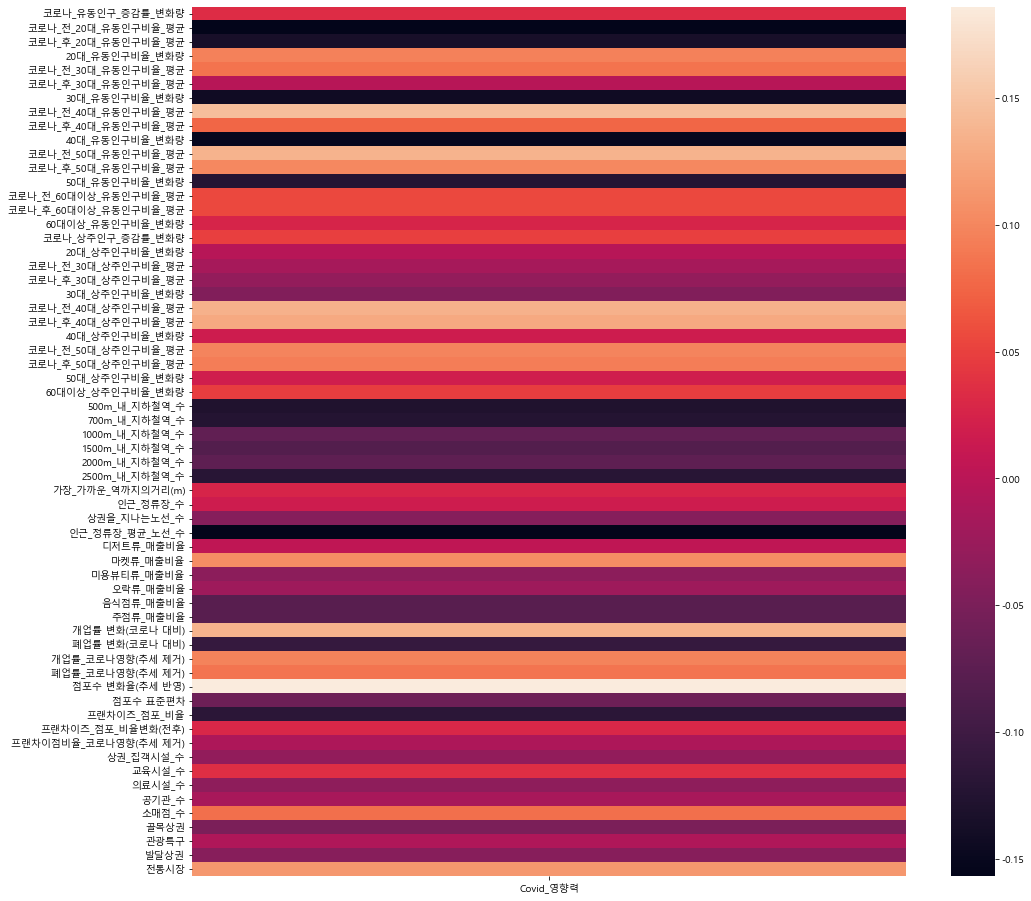

In [31]:
fig, ax = plt.subplots(figsize = (16,16))
sns.heatmap(temp_feature.corr()[['Covid_영향력']].iloc[1:,:], ax = ax)

In [32]:
find_list = ['상권_코드_명'] + corr_good_list
find_value = temp_feature.loc[:, find_list] 

main_final = pd.merge(main_variable, find_value, on = key)
main_final.head(1)

,상권_코드_명,Covid 영향력,상권_평균_점포수(scaling),상권_평균_점포수,segment,상권_구분_코드_명,코로나_전_20대_유동인구비율_평균,코로나_후_20대_유동인구비율_평균,30대_유동인구비율_변화량,코로나_전_40대_유동인구비율_평균,40대_유동인구비율_변화량,코로나_전_50대_유동인구비율_평균,코로나_후_50대_유동인구비율_평균,50대_유동인구비율_변화량,코로나_전_40대_상주인구비율_평균,코로나_후_40대_상주인구비율_평균,500m_내_지하철역_수,700m_내_지하철역_수,2500m_내_지하철역_수,인근_정류장_평균_노선_수,마켓류_매출비율,개업률 변화(코로나 대비),폐업률 변화(코로나 대비),점포수 변화율(추세 반영),프랜차이즈_점포_비율,전통시장
0,가재울로6길,-0.0745,0.1355,76.0,20,골목상권,-0.598356,-0.462149,0.264454,0.721447,-1.06419,0.752794,0.110502,-1.229548,0.699634,1.059657,-1.273117,-1.429306,-0.446183,0.067361,0.107939,0.300231,0.195484,0.647506,0.043713,0


#### [5] 특정 상권에 대한 시각화

- 예시: 고척근린시장
- https://seaborn.pydata.org/examples/palette_choices.html

In [38]:
main_final

,상권_코드_명,Covid 영향력,상권_평균_점포수(scaling),상권_평균_점포수,segment,상권_구분_코드_명,코로나_전_20대_유동인구비율_평균,코로나_후_20대_유동인구비율_평균,30대_유동인구비율_변화량,코로나_전_40대_유동인구비율_평균,40대_유동인구비율_변화량,코로나_전_50대_유동인구비율_평균,코로나_후_50대_유동인구비율_평균,50대_유동인구비율_변화량,코로나_전_40대_상주인구비율_평균,코로나_후_40대_상주인구비율_평균,500m_내_지하철역_수,700m_내_지하철역_수,2500m_내_지하철역_수,인근_정류장_평균_노선_수,마켓류_매출비율,개업률 변화(코로나 대비),폐업률 변화(코로나 대비),점포수 변화율(추세 반영),프랜차이즈_점포_비율,전통시장
0,가재울로6길,-0.0745,0.1355,76.0,20,골목상권,-0.598356,-0.462149,0.264454,0.721447,-1.064190,0.752794,0.110502,-1.229548,0.699634,1.059657,-1.273117,-1.429306,-0.446183,0.067361,0.107939,0.300231,0.195484,0.647506,0.043713,0
1,가좌로7길,-0.1570,-0.2520,53.0,0,골목상권,-0.796131,-0.559308,-0.336299,0.290475,-1.278532,0.700634,0.284676,-0.918860,0.150490,0.004973,-1.273117,-0.016060,-0.992240,0.237160,1.920180,0.227179,-0.622910,-0.022443,0.437705,0
2,갈현로1길,-0.4190,0.1068,74.0,24,골목상권,-1.021009,-0.879174,-1.205146,0.482640,-0.906634,0.667205,0.419442,-0.691048,0.798663,0.799216,-0.359084,-0.722683,-0.992240,-1.264236,1.222803,0.127331,-0.697942,1.065903,0.255242,0
3,갈현로7길,-0.0921,0.0000,67.0,14,골목상권,-1.009389,-0.872625,-0.645103,0.378027,-0.723585,1.067339,0.646312,-1.136083,0.853801,1.143616,-1.273117,-0.722683,-1.356278,-1.275209,1.689673,1.889518,-0.033175,0.606436,-0.710363,0
4,강남시장_동작,-0.0209,-1.9425,11.0,4,전통시장,0.291668,0.456874,-0.812502,-0.704212,-0.491069,-0.326671,-0.317667,0.199075,-0.880274,-1.388944,-0.359084,-0.722683,-0.446183,0.094302,-1.365730,0.041548,2.756145,-2.519993,1.957159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,휘경로2길,-0.2327,1.1811,201.0,17,골목상권,2.094250,1.482785,0.773154,-1.854349,1.737616,-1.698876,-1.368274,1.387217,-0.769237,-0.446256,0.554948,-0.016060,-0.264164,0.226991,0.010019,-0.093358,-0.102529,-0.300947,0.387649,0
304,휘경로3길,-0.2689,0.6085,118.0,16,골목상권,1.388348,0.375315,0.757948,-1.421754,1.758753,-1.116050,-0.174495,1.809625,0.120728,0.316590,0.554948,-0.016060,0.099874,0.070626,-0.876569,-0.875271,-0.419689,-1.018383,0.914048,0
305,흑석로13길,0.0022,-0.2122,55.0,14,골목상권,1.828370,1.238796,1.555449,-1.768917,1.723023,-1.359680,-0.682591,1.621794,-0.307995,0.494874,0.554948,-0.016060,-0.810221,0.362545,-0.144946,-1.154550,-0.292502,0.113600,0.941499,0
306,흑석로9길,-0.3279,0.6085,118.0,16,골목상권,1.683750,1.393013,0.982347,-1.776413,1.036352,-1.306273,-1.168054,0.922804,-1.159017,-1.157259,-0.359084,-0.016060,-0.810221,-0.114425,-0.640996,-1.980054,-1.134107,-0.342017,1.382318,0


## 4. 회복 탄력성 만들기(중요)

- 목적: 각 상권마다 회복 탄력성을 만들어서, 코로나 19가 지난 시저에서 어느 정도 회복했는지 확인
(회복 탄력성이 높은 곳 vs 낮은 곳의 통계치 비교)

- 사용 내용: 예년 증감율 (2016~2018 1, 2분기) vs 코로나 확산기(2020년 1,2분기) vs 코로나 안정기(2021년 1,2분기) 구분

In [39]:
# EDA 그리기(회복 탄력성)

# Task 1. 2018, 20, 21년에 대한 각 매출액 값 가져오기(1,2분기 평균)
column_2018 = [i for i in list(df['년-분기'].unique()) if '2018' in i][:2]
column_2020 = [i for i in list(df['년-분기'].unique()) if '2020' in i][:2]
column_2021 = [i for i in list(df['년-분기'].unique()) if '2021' in i]
column_total = column_2018 + column_2020 + column_2021

point_data = part_01_01.loc[:,column_total]

comparison_value = [] 
for year in [column_2018, column_2020, column_2021]:
    value_part = point_data.loc[:,year].mean(axis = 1)
    comparison_value.append(value_part)
    
comparison_sales = pd.concat(comparison_value, axis = 1)
comparison_sales.columns = ['매출액(이전)','매출액(확산기)', '매출액(안정기)']

# Task2. 기울기 (#1: (20년도 - 18년도) / 18년도,  #2: (21년도 - 20년도) / 18년도 

## 코로나 확산기에 대한 변화율
tilt01_list = []

for tilt01 in range(2):
    tilt01_point = point_data.iloc[:, tilt01]
    tilt01_after = point_data.iloc[:, tilt01 + 2] 
    tilt01_value = tilt01_after.sub(tilt01_point).div(tilt01_point) # (20년 - 18년) / 18년
    tilt01_list.append(tilt01_value)

tilt01 = pd.concat(tilt01_list, axis = 1)
tilt01.columns = ['1분기_매출액변화율(확산기)','2분기_매출액변화율(확산기)']
tilt01_avg = tilt01.mean(axis = 1).round(4)
tilt01_avg = tilt01_avg.reset_index().rename(columns = {0 : '매출액_변화율(확산기)'})

## 코로나 안정기에 대한 변화율
tilt02_list = []
for tilt02 in range(2):
    tilt02_denom = point_data.iloc[:, tilt02]     # 분모(18년도 분기)
    tilt02_point = point_data.iloc[:, tilt02 + 2] # 분자(20년도 분기)
    tilt02_after = point_data.iloc[:, tilt02 + 4] # 분자(21년도 분기)
     
    tilt02_value = tilt02_after.sub(tilt02_point).div(tilt02_denom) # (21년 - 20년) / 18년
    tilt02_list.append(tilt02_value)

    
tilt02 = pd.concat(tilt02_list , axis = 1)
tilt02.columns = ['1분기_매출액변화율(안정기)','2분기_매출액변화율(안정기)']
tilt02_avg = tilt02.mean(axis = 1).round(4)
tilt02_avg = tilt02_avg.reset_index().rename(columns = {0 : '매출액_변화율(안정기)'})

value = pd.merge(tilt01_avg, tilt02_avg, on = '상권_코드_명')

# 최종 data
final_value = pd.merge(comparison_sales.reset_index(), value, on = '상권_코드_명').set_index('상권_코드_명')

In [40]:
final_value.reset_index().query('상권_코드_명 == "응암로14길"')

,상권_코드_명,매출액(이전),매출액(확산기),매출액(안정기),매출액_변화율(확산기),매출액_변화율(안정기)
225,응암로14길,1.457090e+09,928926804.0,1.370552e+09,-0.3376,0.318


#### sample(5개) 상권 탄력성 확인

- 회복탄력성을 보기 위해서 매출액의 위치 좌표(전체적인 상권의 크기가 달라 scaling 진행: 시각화에서만)

In [41]:
def individual_find(street):
    # 개별 상권 가져오기 
    part = final_value.reset_index()
    individual_cm = part[part['상권_코드_명'] == street]
    individual_cm = individual_cm.set_index('상권_코드_명')
    
    total_sale = individual_cm.iloc[:, :3]
    begin = total_sale['매출액(이전)']
    
    recovery_data = total_sale.T.div(begin.values).sub(1).round(2).mul(100).T 
    
    fig, ax = plt.subplots(figsize = (20,8))
    recovery_data.T.plot(ax = ax, title = '{} 회복 탄력성 EDA'.format(street))
    
    #plt.legend(bbox_to_anchor = (1.0,1.0))
    
    #for pos in range(individual_cm.iloc[0, 3:].shape[0]):
    #    plt.text(pos + 1 , recovery_data.iloc[:, pos + 1] * 0.9, individual_cm.iloc[0, pos + 3], fontsize=15)
        
def sampling_find(seed, num): 
    
    # 데이터 정리 
    total_sale = final_value.iloc[:, :3] # 매출 데이터 가져오기
    begin = total_sale['매출액(이전)']   # 매출 데이터 中 코로나 이전 매출액(2018년 1,2분기 평균)을 기준
    
    recovery_data = total_sale.T.div(begin.values).sub(1).round(2).mul(100).T # 코로나 이전 매출액 대비해서 증가율 확인
    
    # 시각화
    recovery_data.sample(num).T.plot(figsize = (20,10), title = 'smapling {}개의 회복 탄력성 확인'.format(num))
    plt.legend(bbox_to_anchor = (1.0,1.0))

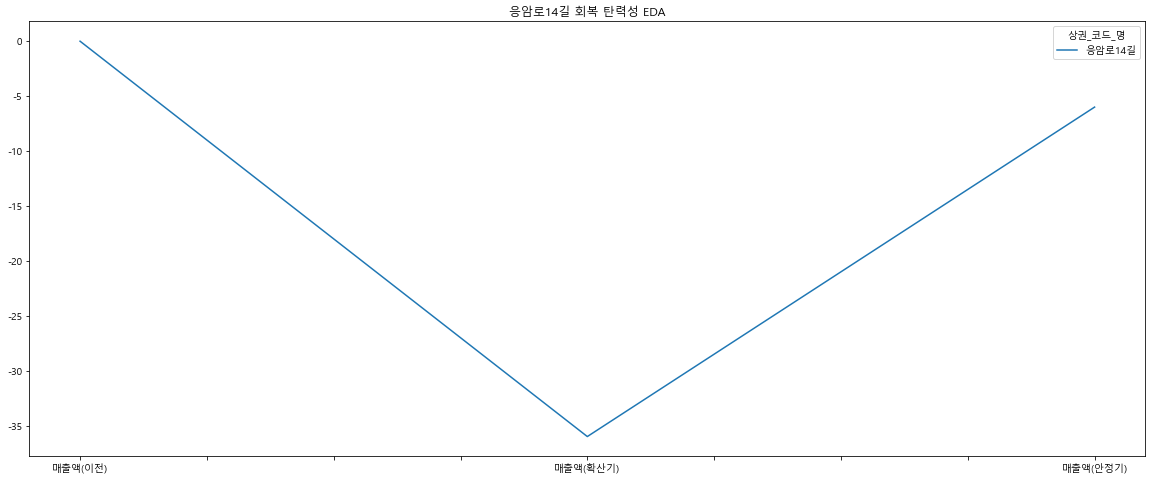

In [42]:
individual_find('응암로14길')

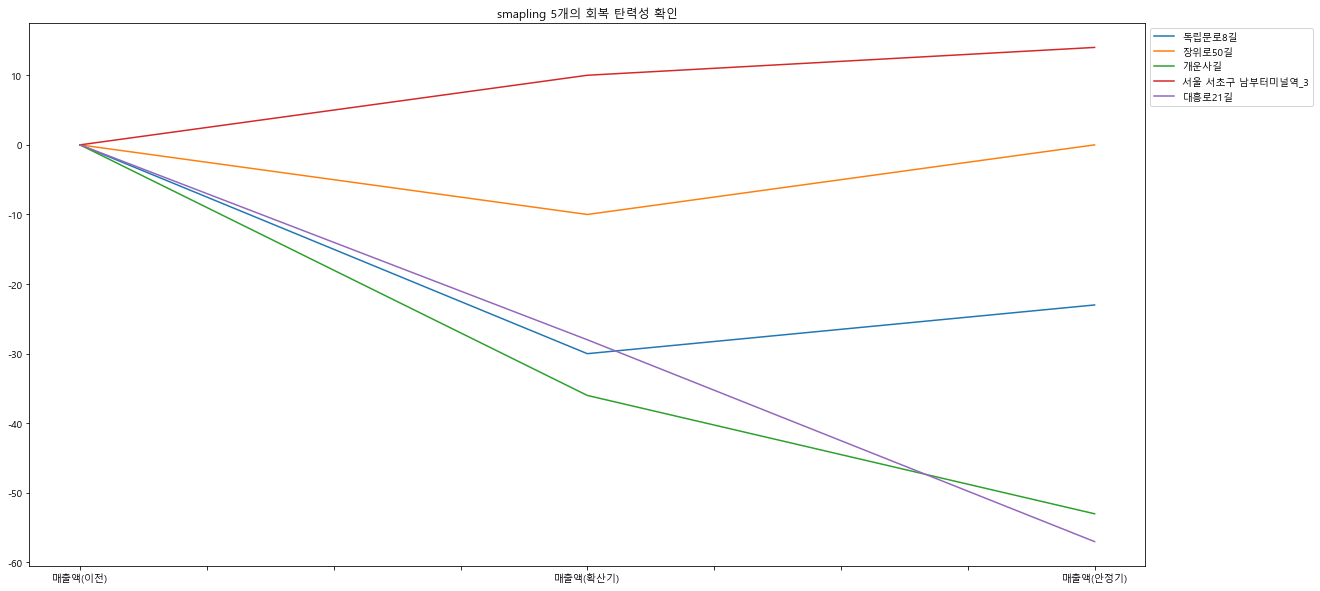

In [43]:
sampling_find(0,5)

#### sample 상권확인하기(순수 매출액)

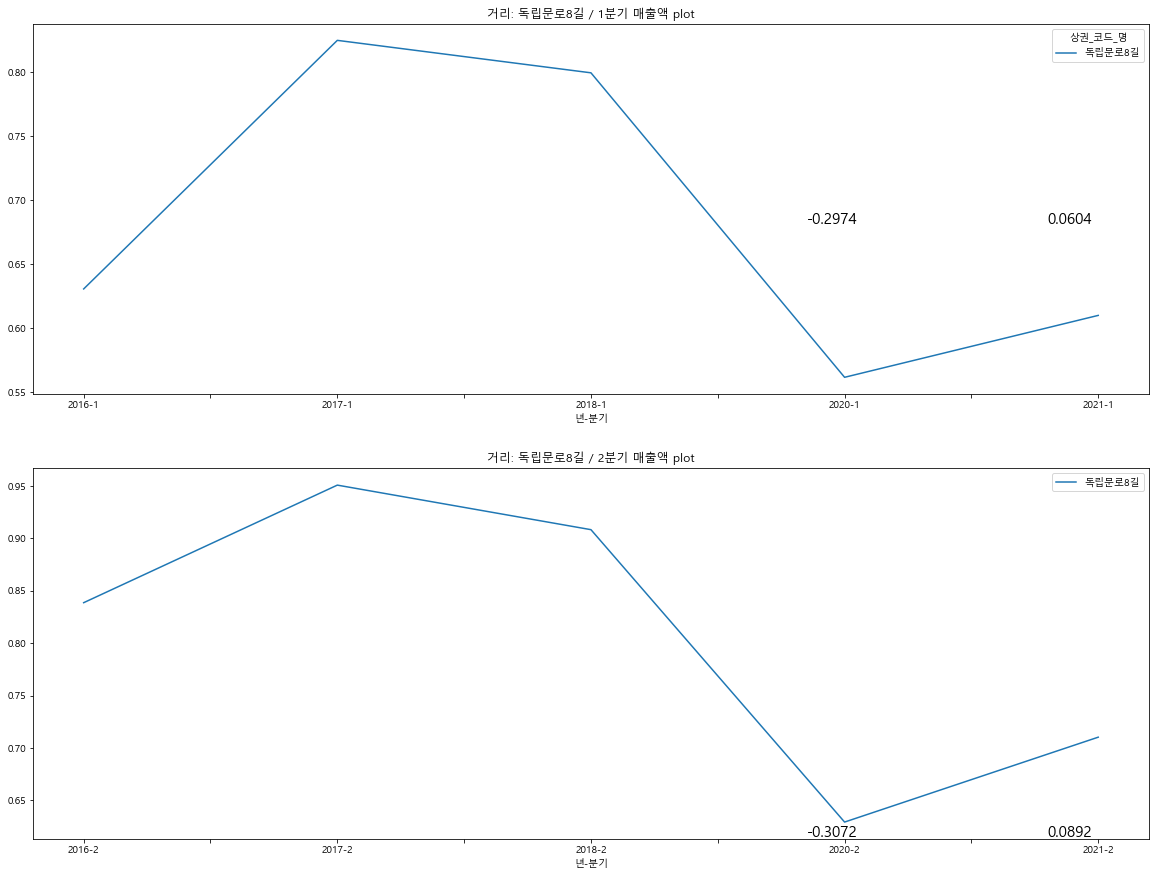

년-분기,2016-1,2016-2,2017-1,2017-2,2018-1,2018-2,2020-1,2020-2,2021-1,2021-2
상권_코드_명,,,,,,,,,,
독립문로8길,630864028.0,838673747.0,824982257.0,950884585.0,799634215.0,908366734.0,561857707.0,629290529.0,610195160.0,710307119.0


In [44]:
# 분기별 증가추세 확인(1,2분기) : 따로 확인하는 것은 분기별 scaling은 다르지만 전반적인 추세는 비슷
def change_of_rate_plot(street):
    a = final_data[final_data['상권_코드_명'] == street].query('기준_분기_코드 == 1 or 기준_분기_코드 == 2') # 특정 상권 추출

    quarter_col_12 = [i for i in list(a['년-분기'].unique()) if '2019' not in i][:-2] + ['2021-1','2021-2']  # colume명 추출
    quarter_01_col = [i for i in quarter_col_12 if '-1' in i]  # 1분기 columne 명 가져오기
    quarter_02_col = [i for i in quarter_col_12 if '-2' in i]  # 2분기 columne 명 가져오기
    
    # 1분기 2분기 데이터만 나눠서 시각화(년도별)
    quarter_first = a.pivot_table(index = '상권_코드_명', columns = '년-분기', 
                                  values = '분기당_매출_금액', aggfunc = 'sum').loc[:,quarter_01_col]
    quarter_second = a.pivot_table(index = '상권_코드_명', columns = '년-분기', 
                                  values = '분기당_매출_금액', aggfunc = 'sum').loc[:,quarter_02_col]
    
    # 각 분기별 변화율 표시 
    quarter_first_change = pd.concat(tilt01_list, axis = 1).round(4)
    quarter_first_change.columns = ['매출액_변화율(1분기/확산기)', '매출액_변화율(2분기/확산기)']
    
    quarter_second_change = pd.concat(tilt02_list, axis = 1).round(4)
    quarter_second_change.columns = ['매출액_변화율(1분기/안전기)', '매출액_변화율(2분기/안전기)']
    
    change_data = pd.merge(quarter_first_change.reset_index(), 
                           quarter_second_change.reset_index(), on = '상권_코드_명')
    change_data = change_data[change_data['상권_코드_명'] == street].set_index('상권_코드_명')
    
    change_data = change_data[['매출액_변화율(1분기/확산기)','매출액_변화율(1분기/안전기)',
                               '매출액_변화율(2분기/확산기)','매출액_변화율(2분기/안전기)']]

    # plot 그리기(각 분기별 추세 확인)
    fig, ax = plt.subplots(2, 1, figsize = (20,15))

    quarter_first.iloc[:, :].T.div(1e9).plot(ax = ax[0], title = '거리: {} / 1분기 매출액 plot'.format(street))
    for pos in range(2):
        x_value = (3 + pos) * 0.95
        if  (abs(quarter_first.iloc[:, pos + 3]) / 1e9).round(5)[0] <=1 : 
            y_value = 1.2
        else:
            y_value = (abs(quarter_first.iloc[:, pos + 3]) / 1e9).round(5) + 0.75
            
        plt.text(x_value, y_value, change_data.iloc[0, pos], fontsize=15)

    quarter_second.iloc[:, :].T.div(1e9).plot(ax = ax[1], title = '거리: {} / 2분기 매출액 plot'.format(street))
    ax[1].legend(bbox_to_anchor = (1.0,1.0))
    for pos in range(2):
        x_value =(3 + pos) * 0.95
        if  (abs(quarter_second.iloc[:, pos + 3]) / 1e9).round(5)[0] <=1 : 
            y_value = 0.6 + 0.015
        else:
            y_value = (abs(quarter_second.iloc[:, pos + 3]) / 1e9).round(5) + 0.015
            
        plt.text(x_value, y_value, change_data.iloc[0, pos+2], fontsize=15)
        
    plt.show()
    display(a.pivot_table(index = '상권_코드_명', columns = '년-분기', 
                          values = '분기당_매출_금액', aggfunc = 'sum').loc[:,quarter_col_12])
    
change_of_rate_plot('독립문로8길')

#### 사분할 그리기 

- 예시 : https://rfriend.tistory.com/415
- 의미 있는 분할을 위해서 size를 다양하게 시도

In [45]:
# 반올림하기 
tilt01 = tilt01.round(4)
tilt02 = tilt02.round(4)

cf_past = result_before_covid[['1분기 예년 증감 평균','2분기 예년 증감 평균']].agg(lambda x: (x-1))

# 기존 상권의 추세 제거하기(확산기 매출액 변화율 - 예년 평균 변화율)
spread_list = []
stabilize_list = []

for quarter in range(2):
    past_point = cf_past.iloc[:, quarter]
    spread_value = tilt01.iloc[:, quarter]
    stability_value = tilt02.iloc[:, quarter]
    
    v1 = spread_value - past_point    # 확산기 매출액 변화율 - 예년 평균 변화율 (분기별)
    v2 = stability_value - past_point # 안정기 매출액 변화율 - 예년 평균 변화율 (분기별)
    
    spread_list.append(v1)
    stabilize_list.append(v2)
    
spread_avg = pd.concat(spread_list, axis = 1).mean(axis= 1).round(4).reset_index()
stabilize_avg = pd.concat(stabilize_list, axis = 1).mean(axis= 1).round(4).reset_index()

one_step = pd.merge(spread_avg, stabilize_avg, on = '상권_코드_명').set_index('상권_코드_명')
one_step.columns = ['매출액_변화율(확산기/추세제거)','매출액_변화율(안정기/추세제거)']

two_step = pd.merge(comparison_sales.reset_index(), one_step.reset_index(), on = '상권_코드_명').set_index('상권_코드_명')

In [46]:
copy = pd.merge(two_step, result_final.reset_index()[['상권_코드_명','상권_평균_점포수']], on = '상권_코드_명')

In [47]:
df = final_data.groupby(['상권_코드_명', '년-분기'])['분기당_매출_금액'].sum().reset_index()
df = df.rename(columns = {'분기당_매출_금액': '분기당_총매출금액'})

# seed 고정
seed = 0
np.random.seed(seed)

part_01_01 = df.set_index(['년-분기','상권_코드_명'])['분기당_총매출금액'].unstack().transpose()

#### 상권 분석을 위한 사용 데이터 불러오기

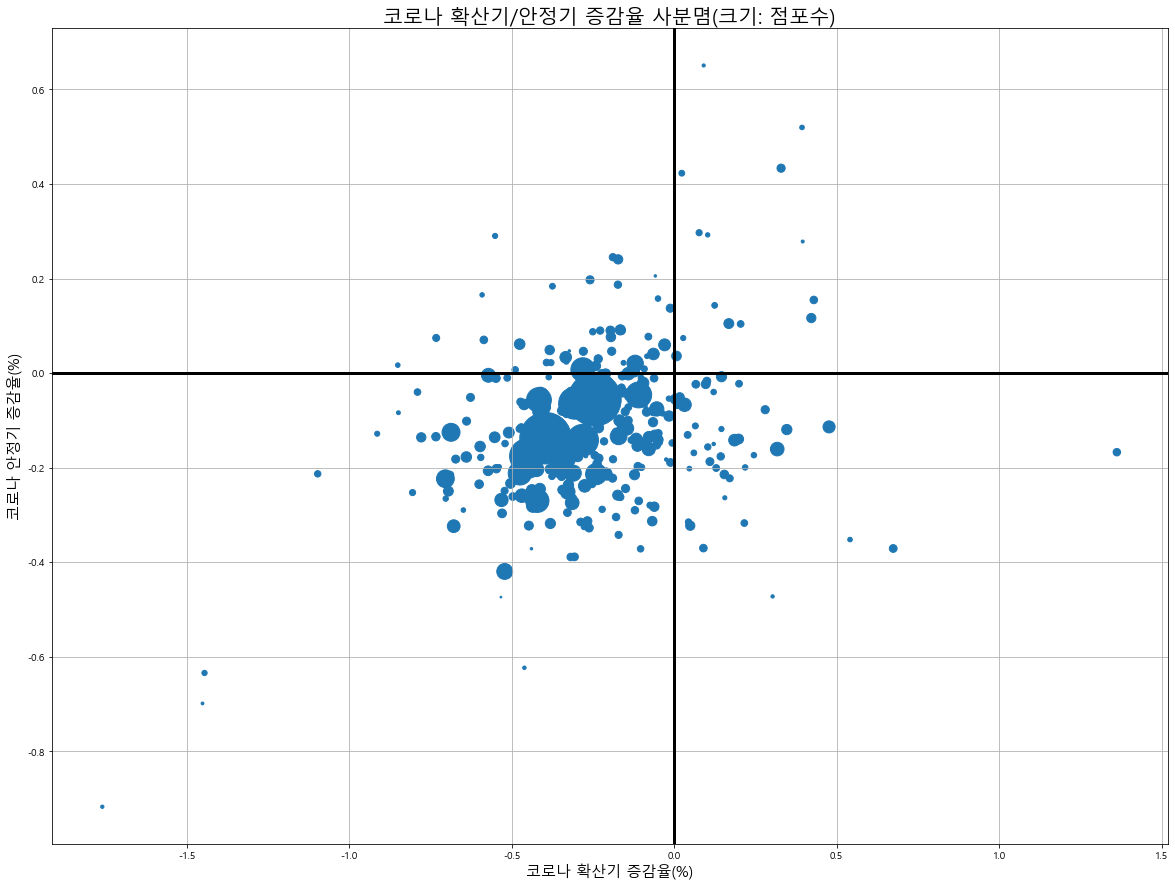

,상권_코드_명,매출액(이전),매출액(확산기),매출액(안정기),매출액_변화율(확산기/추세제거),매출액_변화율(안정기/추세제거),상권_평균_점포수
91,명동 남대문 북창동 다동 무교동 관광특구,2.590790e+11,1.829712e+11,1.564162e+11,-0.2444,-0.0558,2822.0
296,홍익대학교 주변,2.226325e+11,1.343635e+11,1.035539e+11,-0.3954,-0.1377,2657.0
151,서울 서대문구 신촌역,8.748015e+10,4.889131e+10,3.482578e+10,-0.4529,-0.1756,1189.0
92,명동거리,1.206309e+11,7.054154e+10,4.928597e+10,-0.3057,-0.0636,1024.0
240,잠실 관광특구,9.562512e+10,7.885547e+10,7.558111e+10,-0.2813,-0.1420,1004.0


In [48]:
def drawling_scatter(x, y):
    fig, ax = plt.subplots(figsize =(20,15))

    ax.scatter(x,y, cmap='coolwarm', s = copy['상권_평균_점포수'])

    ax.set_xlabel("코로나 확산기 증감율(%)", fontsize=15)
    ax.set_ylabel("코로나 안정기 증감율(%)", fontsize=15)
    ax.set_title('코로나 확산기/안정기 증감율 사분몀(크기: 점포수)', fontsize = 20)
    ax.grid()

    # X,Y 축 고정
    #ax.set_xlim([-3,4])
    #ax.set_ylim([-3,4])

    # x,y축 그리기
    plt.axvline(x = 0, color='black', linewidth=3)
    plt.axhline(y = 0, color='black', linewidth=3)
    # ax.legend(fontsize=12, loc='upper left')

    # 사분면 정의 된거 text 표시
    #plt.text(3.0, 3.0, '순환형', fontsize=25, color='red')
    #plt.text(3.0, -2.5, '성장형', fontsize=25, color='red') 
    #plt.text(-2.0, -2.5, '정체형', fontsize=25, color='red') 
    #plt.text(-2.0, 3.0, '쇠퇴형', fontsize=25, color='red') 

    plt.show()
    
drawling_scatter( copy['매출액_변화율(확산기/추세제거)'],copy['매출액_변화율(안정기/추세제거)'])

copy.sort_values(by = '상권_평균_점포수', ascending = False).head()

## 상권 분석(회복 탄력성에 따른)